In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_palette("husl")
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


### SUMMARY OF THE PROJECT:
The e-charging requests (from cars) are served with energy coming from the PV, the local battery, and/or the external grid. The system is programmed to avoid that the power drawn from the external grid exceeds the value of a threshold (“DEMAND_LIMIT”). This is known as peak-shaving, e.g., when the power drawn from the grid exceeds the DEMAND_LIMIT threshold, the local battery starts being used providing energy to “shave the peak”. Obviously, this cannot happen always and sometimes the threshold is violated (e.g., when several cars are attached, and the local battery has a low state of charge). In the data you can see when and how often this happens.

### The goal of the project is to perform “knowledge-base completion” and rule learning, possibly with neuro-symbolic approaches.
 
For ground truth, at the moment the following rules are applied for the behavior of the local battery, based on its State-Of-Charge (SOC):
SOC > 80%: e-cars charging is completely covered by the local battery
40% < SOC < 80%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
SOC < 40%:
if GARAGE_EXTERNAL_POWER > DEMAND_LIMIT, e-cars charging power is covered by local battery.
If GARAGE_EXTERNAL_POWER < DEMAND_LIMIT, local battery is charged from the grid.
SOC < 15%: Battery discharging is stopped due to battery health

### Research Questions:
If the values above are not specified, can we learn them? E.g. with Hybrid AI / Neuro-symbolic approaches? (knowledge base completion with LNN?)

Are there other rules in the microgrid, that can be learned from the data?


Once the rules are learned and the values above are found (e.g., 15%, 40%, 80% thresholds), is it possible to find better values, e.g., that minimize the risk of violating the DEMAND_LIMIT?


One potential idea is to specify the rules in term of logic formula and learn/complete/optimize them with Neuro-symbolic AI.

In [2]:
staticLimit = pd.read_csv('Stud_E-mobility_data_staticLimit.csv')

In [3]:
staticLimit.head(20)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
0,2023-10-05 00:01:00+00:00,1.244171,50.0,1.0,40.5,-0.338,0.000000,0.0,0.008693,0.0,...,0.000000,0.006914,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.154965
1,2023-10-05 00:02:00+00:00,1.244171,50.0,1.0,40.5,-0.372,0.000000,0.0,0.008693,0.0,...,0.000000,0.007550,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.155586
2,2023-10-05 00:03:00+00:00,1.244171,50.0,1.0,40.5,-0.393,0.000000,0.0,0.008693,0.0,...,0.000000,0.006996,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157340
3,2023-10-05 00:04:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008693,0.0,...,0.000000,0.007392,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.158009
4,2023-10-05 00:05:00+00:00,1.244171,50.0,1.0,40.5,-0.371,0.000000,0.0,0.008693,0.0,...,0.000000,0.007188,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.158804
5,2023-10-05 00:06:00+00:00,1.339874,50.0,1.0,40.5,-0.477,0.000000,0.0,0.008693,0.0,...,0.000000,0.007132,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158213
6,2023-10-05 00:07:00+00:00,1.339874,50.0,1.0,40.5,-0.373,0.000000,0.0,0.008693,0.0,...,0.000000,0.007680,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.158075
7,2023-10-05 00:08:00+00:00,1.244171,50.0,1.0,40.5,-0.359,0.000000,0.0,0.008550,0.0,...,0.000977,0.006988,0.000977,0.010233,0.000000,0.010435,0.000000,0.010112,0.007812,0.156482
8,2023-10-05 00:09:00+00:00,1.244171,50.0,1.0,40.5,-0.339,0.000000,0.0,0.008550,0.0,...,0.000000,0.007089,0.000000,0.010233,0.000977,0.010435,0.000000,0.010112,0.000000,0.156322
9,2023-10-05 00:10:00+00:00,1.244171,50.0,1.0,40.5,-0.292,0.000000,0.0,0.008633,0.0,...,0.000000,0.007034,0.000000,0.010233,0.000000,0.010435,0.000000,0.010112,0.000000,0.157987


In [4]:
staticLimit.tail(20)

,_time,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
59422,2023-11-18 23:40:00+00:00,1.244171,50.0,1.0,41.0,-0.447,0.000000,0.0,0.007734,0.000000,...,0.000000,0.005391,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.157286
59423,2023-11-18 23:41:00+00:00,1.244171,50.0,1.0,41.0,-0.459,0.000000,0.0,0.007542,0.000000,...,0.000000,0.005918,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.157555
59424,2023-11-18 23:42:00+00:00,1.148468,50.0,1.0,41.0,-0.452,0.000000,0.0,0.007542,0.000000,...,0.000000,0.006059,0.000000,0.010307,0.001953,0.010465,0.000000,0.010287,0.000000,0.156440
59425,2023-11-18 23:43:00+00:00,1.244171,50.0,1.0,41.0,-0.469,0.000000,0.0,0.007360,0.000000,...,0.000000,0.005715,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.157298
59426,2023-11-18 23:44:00+00:00,1.148468,50.0,1.0,41.0,-0.442,0.000000,0.0,0.007553,0.000000,...,0.000000,0.005604,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.157172
59427,2023-11-18 23:45:00+00:00,1.244171,50.0,1.0,41.0,-0.442,0.000000,0.0,0.007553,0.000000,...,0.000000,0.005869,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.156478
59428,2023-11-18 23:46:00+00:00,1.244171,50.0,1.0,41.0,-0.421,0.000000,0.0,0.007553,0.000000,...,0.000000,0.006017,0.000000,0.010307,0.000000,0.010465,0.001953,0.010287,0.000000,0.157094
59429,2023-11-18 23:47:00+00:00,1.148468,50.0,1.0,41.0,-0.442,0.101562,0.0,0.007553,0.000000,...,0.001953,0.005632,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.007812,0.156897
59430,2023-11-18 23:48:00+00:00,1.052765,50.0,1.0,41.0,-0.439,0.000000,0.0,0.007606,0.000000,...,0.000000,0.006098,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.152954
59431,2023-11-18 23:49:00+00:00,1.148468,50.0,1.0,41.0,-0.421,0.000000,0.0,0.007606,0.000000,...,0.000000,0.006048,0.000000,0.010307,0.000000,0.010465,0.000000,0.010287,0.000000,0.148245


In [5]:
staticLimit.describe()

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
count,59442.000000,59442.0,59442.0,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,...,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000,59442.000000
mean,16.289759,50.0,1.0,40.146942,-0.464677,0.058751,0.050882,0.725957,0.012497,0.013051,...,0.024936,1.397854,0.017482,1.015422,0.018566,1.051943,0.025252,1.435265,0.169159,9.665066
std,19.406290,0.0,0.0,5.453018,14.480506,0.358806,0.339166,1.309800,0.067592,0.324930,...,0.223362,2.768573,3.043279,2.521278,0.161284,2.722164,0.286048,3.194861,1.120542,22.522631
min,-9.283169,50.0,1.0,7.500000,-53.692001,0.000000,-0.101562,-0.039667,0.000000,0.000000,...,0.000000,-0.007193,-524.167969,0.009783,-0.017578,0.009795,0.000000,0.009802,0.000000,0.009000
25%,1.244171,50.0,1.0,40.500000,-0.482000,0.000000,0.000000,0.006161,0.000000,0.000000,...,0.000000,0.005797,0.000000,0.010202,0.000000,0.010320,0.000000,0.010211,0.000000,0.150472
50%,6.699247,50.0,1.0,40.500000,-0.351000,0.000000,0.000000,0.008210,0.000000,0.000000,...,0.000000,0.007424,0.000000,0.010252,0.000000,0.010370,0.000000,0.010260,0.000000,0.159256
75%,26.031271,50.0,1.0,41.000000,-0.225000,0.000000,0.000000,0.887282,0.015625,0.000000,...,0.029297,1.606894,0.000977,0.010340,0.000977,0.010431,0.001953,0.010552,0.007812,0.169050
max,112.929680,50.0,1.0,54.500000,72.433006,65.699219,55.500000,7.470151,14.628906,76.445312,...,40.796875,11.713392,524.398438,11.637885,31.630859,11.531826,68.082031,11.560207,190.648438,80.319511


In [6]:
staticLimit.columns

Index(['_time', 'GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER'],
      dtype='object')

In [9]:
data_for_corr = staticLimit[['GARAGE_EXTERNAL_POWER', 'DEMAND_LIMIT',
       'DEMAND_LIMIT_INDICATOR', 'BATTERY_SOC', 'BATTERY_DISCHARGE_POWER',
       'BATTERY_CHARGED_ENERGY', 'BATTERY_DISCHARGED_ENERGY', 'PV_POWER',
       'PV_ENERGY', 'WALLBOX_ALPHA_ENERGY', 'WALLBOX_ALPHA_POWER',
       'WALLBOX_1_ENERGY', 'WALLBOX_1_POWER', 'WALLBOX_2_ENERGY',
       'WALLBOX_2_POWER', 'WALLBOX_3_ENERGY', 'WALLBOX_3_POWER',
       'WALLBOX_A_ENERGY', 'WALLBOX_A_POWER', 'WALLBOX_B_ENERGY',
       'WALLBOX_B_POWER', 'WALLBOX_C_ENERGY', 'WALLBOX_C_POWER',
       'WALLBOX_FASTCHARGER_ENERGY', 'WALLBOX_FASTCHARGER_POWER']]

In [10]:
full_correlation = data_for_corr.corr()

In [11]:
full_correlation

,GARAGE_EXTERNAL_POWER,DEMAND_LIMIT,DEMAND_LIMIT_INDICATOR,BATTERY_SOC,BATTERY_DISCHARGE_POWER,BATTERY_CHARGED_ENERGY,BATTERY_DISCHARGED_ENERGY,PV_POWER,PV_ENERGY,WALLBOX_ALPHA_ENERGY,...,WALLBOX_3_ENERGY,WALLBOX_3_POWER,WALLBOX_A_ENERGY,WALLBOX_A_POWER,WALLBOX_B_ENERGY,WALLBOX_B_POWER,WALLBOX_C_ENERGY,WALLBOX_C_POWER,WALLBOX_FASTCHARGER_ENERGY,WALLBOX_FASTCHARGER_POWER
GARAGE_EXTERNAL_POWER,1.000000,NaN,NaN,-0.508970,0.008528,0.224724,0.247573,0.191564,0.063723,0.048859,...,0.041429,0.211282,0.002465,0.182052,0.054448,0.196256,0.049241,0.280510,0.236171,0.717202
DEMAND_LIMIT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DEMAND_LIMIT_INDICATOR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BATTERY_SOC,-0.508970,NaN,NaN,1.000000,0.012611,-0.137793,-0.144498,-0.054154,-0.017102,-0.042671,...,-0.025288,-0.124177,-0.001597,-0.116676,-0.036523,-0.130682,-0.013417,-0.074131,-0.116157,-0.342181
BATTERY_DISCHARGE_POWER,0.008528,NaN,NaN,0.012611,1.000000,-0.355790,0.323984,0.029900,0.009843,0.012303,...,0.004652,0.021858,-0.000007,-0.000615,0.014337,0.050392,0.004017,0.021766,0.206878,0.626435
BATTERY_CHARGED_ENERGY,0.224724,NaN,NaN,-0.137793,-0.355790,1.000000,0.746920,0.020929,0.373738,0.756976,...,0.715906,0.008715,0.014519,0.018032,0.507266,0.003505,0.762786,0.027945,0.795925,-0.044423
BATTERY_DISCHARGED_ENERGY,0.247573,NaN,NaN,-0.144498,0.323984,0.746920,1.000000,0.043309,0.375188,0.692916,...,0.660362,0.024409,0.019065,0.019536,0.508336,0.039157,0.691971,0.044369,0.959359,0.395467
PV_POWER,0.191564,NaN,NaN,-0.054154,0.029900,0.020929,0.043309,1.000000,0.318672,0.021055,...,0.029665,0.155326,0.002657,0.198989,0.051721,0.196261,0.021172,0.125036,0.045467,0.147428
PV_ENERGY,0.063723,NaN,NaN,-0.017102,0.009843,0.373738,0.375188,0.318672,1.000000,0.430028,...,0.416140,0.054374,0.010849,0.062566,0.452497,0.061771,0.292790,0.040689,0.391535,0.045271
WALLBOX_ALPHA_ENERGY,0.048859,NaN,NaN,-0.042671,0.012303,0.756976,0.692916,0.021055,0.430028,1.000000,...,0.757892,0.017576,0.002377,0.015413,0.422860,0.010970,0.946401,0.021944,0.713218,0.011833


In [7]:

correlation = staticLimit[['BATTERY_SOC', 'GARAGE_EXTERNAL_POWER']].corr()
print(correlation)


                       BATTERY_SOC  GARAGE_EXTERNAL_POWER
BATTERY_SOC                1.00000               -0.50897
GARAGE_EXTERNAL_POWER     -0.50897                1.00000


## Data inspection and segmentation

In [15]:
missing_values = staticLimit.isnull().sum()
data_types = staticLimit.dtypes

In [16]:
missing_values, data_types

(_time                         0
 GARAGE_EXTERNAL_POWER         0
 DEMAND_LIMIT                  0
 DEMAND_LIMIT_INDICATOR        0
 BATTERY_SOC                   0
 BATTERY_DISCHARGE_POWER       0
 BATTERY_CHARGED_ENERGY        0
 BATTERY_DISCHARGED_ENERGY     0
 PV_POWER                      0
 PV_ENERGY                     0
 WALLBOX_ALPHA_ENERGY          0
 WALLBOX_ALPHA_POWER           0
 WALLBOX_1_ENERGY              0
 WALLBOX_1_POWER               0
 WALLBOX_2_ENERGY              0
 WALLBOX_2_POWER               0
 WALLBOX_3_ENERGY              0
 WALLBOX_3_POWER               0
 WALLBOX_A_ENERGY              0
 WALLBOX_A_POWER               0
 WALLBOX_B_ENERGY              0
 WALLBOX_B_POWER               0
 WALLBOX_C_ENERGY              0
 WALLBOX_C_POWER               0
 WALLBOX_FASTCHARGER_ENERGY    0
 WALLBOX_FASTCHARGER_POWER     0
 dtype: int64,
 _time                         datetime64[ns, UTC]
 GARAGE_EXTERNAL_POWER                     float64
 DEMAND_LIMIT            

In [17]:
staticLimit['_time'] = pd.to_datetime(staticLimit['_time'], utc=True)

In [18]:
def battery_usage(row):
    if row['BATTERY_SOC'] > 80:
        return 'Discharge for all needs'
    elif 40 < row['BATTERY_SOC'] <= 80:
        if row['GARAGE_EXTERNAL_POWER'] > row['DEMAND_LIMIT']:
            return 'Discharge for demand'
        else:
            return 'Standby'
    elif 15 <= row['BATTERY_SOC'] <= 40:
        if row['GARAGE_EXTERNAL_POWER'] > row['DEMAND_LIMIT']:
            return 'Discharge for demand'
        else:
            return 'Charge from grid'
    else:  # SOC < 15%
        return 'No discharge'

In [20]:
# Let's apply anew coloumn 'BATTERY_USAGE'
staticLimit['BATTERY_USAGE'] = staticLimit.apply(battery_usage, axis=1)

In [21]:
# Check for demand limit violations and when the battery discharges to mitigate it
staticLimit['DEMAND_VIOLATION'] = staticLimit['GARAGE_EXTERNAL_POWER'] > staticLimit['DEMAND_LIMIT']
staticLimit['BATTERY_DISCHARGE_ACTION'] = (staticLimit['DEMAND_VIOLATION'] & (staticLimit['BATTERY_DISCHARGE_POWER'] < 0))


In [22]:
violations_summary = staticLimit['DEMAND_VIOLATION'].value_counts(normalize=True)
battery_actions_summary = staticLimit['BATTERY_DISCHARGE_ACTION'].value_counts(normalize=True)


In [23]:
violations_summary, battery_actions_summary

(DEMAND_VIOLATION
 False    0.923455
 True     0.076545
 Name: proportion, dtype: float64,
 BATTERY_DISCHARGE_ACTION
 False    0.977255
 True     0.022745
 Name: proportion, dtype: float64)

Demand Violations: About $7.65$% of the time, the garage's external power demand exceeds the set DEMAND_LIMIT. This indicates times when the demand threshold is violated.

The local battery discharges to mitigate these demand violations about $2.27$% of the time. This is relatively low compared to the number of violations, suggesting that the battery might often be at a lower state of charge (SOC) or other conditions prevent it from discharging (e.g., SOC below 15%).

These insights suggest that while there is a mechanism in place for the battery to help manage peak demand, it might not always be effective due to various constraints such as battery SOC or multiple simultaneous charging requests.

In [25]:
# Create time-based segments
staticLimit['hour'] = staticLimit['_time'].dt.hour
staticLimit['time_of_day'] = pd.cut(staticLimit['hour'], bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'], right=False)
staticLimit['day_of_week'] = staticLimit['_time'].dt.day_name()
staticLimit['is_weekend'] = staticLimit['day_of_week'].isin(['Saturday', 'Sunday'])

# Create SOC range segments
soc_conditions = [
    (staticLimit['BATTERY_SOC'] > 80),
    (staticLimit['BATTERY_SOC'] > 40) & (staticLimit['BATTERY_SOC'] <= 80),
    (staticLimit['BATTERY_SOC'] >= 15) & (staticLimit['BATTERY_SOC'] <= 40),
    (staticLimit['BATTERY_SOC'] < 15)
]
soc_labels = ['> 80%', '41% - 80%', '15% - 40%', '< 15%']
staticLimit['SOC_range'] = staticLimit.select_dtypes(include=['category']).apply(lambda x: pd.Categorical(x, ordered=True))
staticLimit['SOC_range'] = pd.Categorical(pd.cut(staticLimit['BATTERY_SOC'], bins=[0, 15, 40, 80, 100], labels=soc_labels, right=True))

# Summarize the created segments
segmentation_summary = {
    "Time of Day": staticLimit['time_of_day'].value_counts(),
    "Day of the Week": staticLimit['day_of_week'].value_counts(),
    "Is Weekend": staticLimit['is_weekend'].value_counts(),
    "SOC Range": staticLimit['SOC_range'].value_counts()
}




In [26]:
segmentation_summary

{'Time of Day': time_of_day
 Morning      15111
 Night        15089
 Afternoon    14653
 Evening      14589
 Name: count, dtype: int64,
 'Day of the Week': day_of_week
 Saturday     9545
 Thursday     9509
 Sunday       8639
 Monday       8638
 Friday       8434
 Wednesday    8114
 Tuesday      6563
 Name: count, dtype: int64,
 'Is Weekend': is_weekend
 False    41258
 True     18184
 Name: count, dtype: int64,
 'SOC Range': SOC_range
 15% - 40%    47908
 41% - 80%    11317
 > 80%          217
 < 15%            0
 Name: count, dtype: int64}

The data indicates a slightly higher activity on Saturdays and Thursdays. The lowest activity occurs on Tuesdays. This pattern could reflect variations in travel or usage patterns during different days of the week.

There's a significant difference between weekday and weekend entries, with weekdays seeing more activity. This suggests that the charging facilities are utilized more during the weekdays, which could be linked to regular commuting or commercial activity patterns.

Most entries fall within the 15% - 40% SOC range, indicating that the battery often operates within this range. The very few entries above 80% SOC suggest that the battery rarely is fully charged, or such high charge levels are quickly utilized. Notably, there are no entries with SOC below 15%, which aligns with the operational constraint that discharging is stopped at SOC below 15% to protect battery health.

## Data visualization 

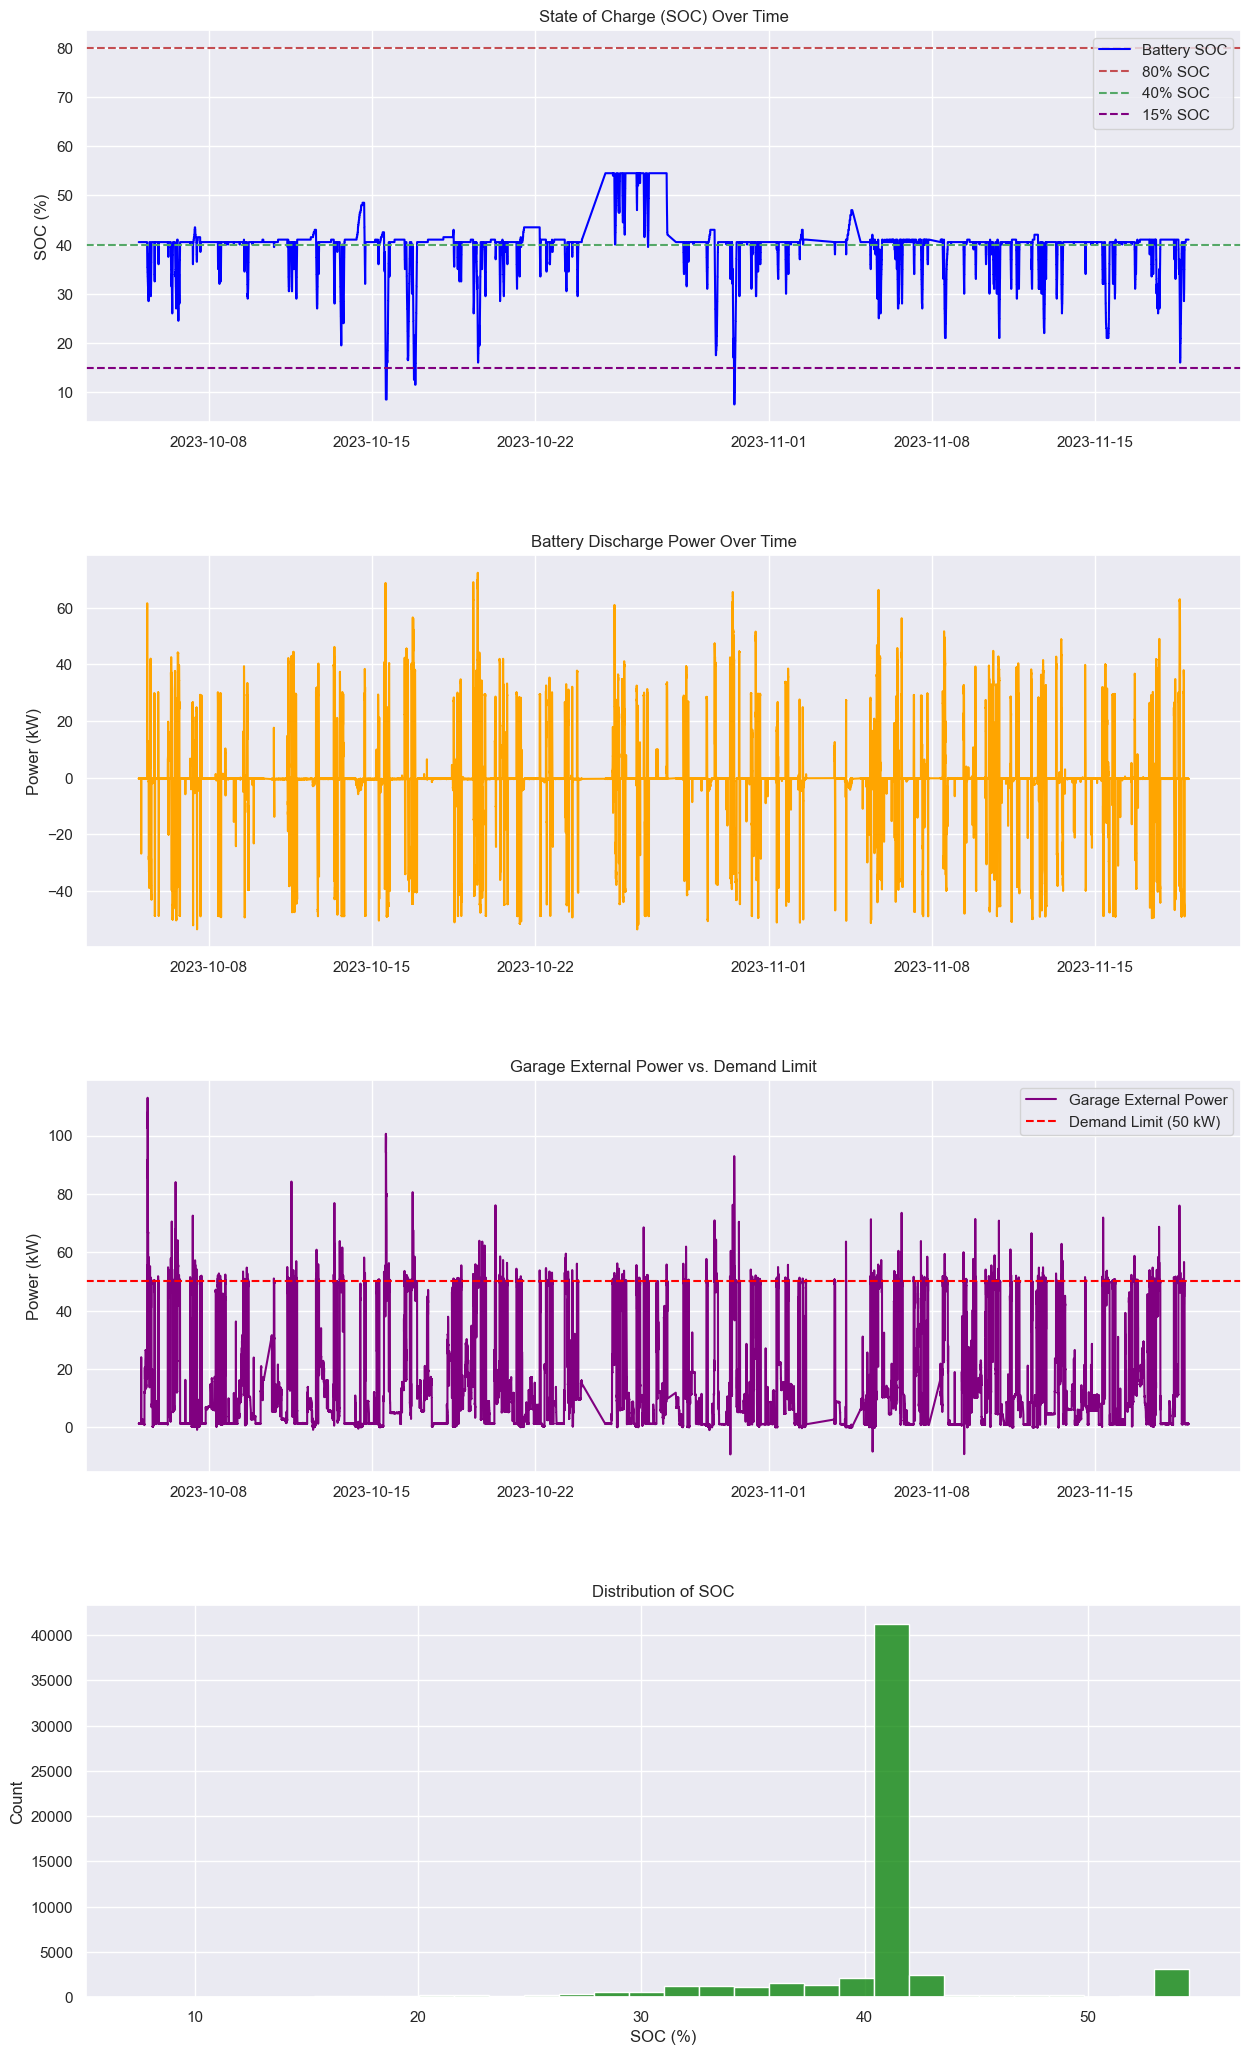

In [13]:
staticLimit['_time'] = pd.to_datetime(staticLimit['_time'])

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(14, 22))
fig.tight_layout(pad=6.0)

#SOC Over Time
axes[0].plot(staticLimit['_time'], staticLimit['BATTERY_SOC'], label='Battery SOC', color='blue')
axes[0].axhline(y=80, color='r', linestyle='--', label='80% SOC')
axes[0].axhline(y=40, color='g', linestyle='--', label='40% SOC')
axes[0].axhline(y=15, color='purple', linestyle='--', label='15% SOC')
axes[0].set_title('State of Charge (SOC) Over Time')
axes[0].set_ylabel('SOC (%)')
axes[0].legend()

# Battery Discharge/Charge Power Over Time
axes[1].plot(staticLimit['_time'], staticLimit['BATTERY_DISCHARGE_POWER'], label='Battery Discharge Power', color='orange')
axes[1].set_title('Battery Discharge Power Over Time')
axes[1].set_ylabel('Power (kW)')

# Garage External Power vs. Demand Limit
axes[2].plot(staticLimit['_time'], staticLimit['GARAGE_EXTERNAL_POWER'], label='Garage External Power', color='purple')
axes[2].axhline(y=50, color='red', linestyle='--', label='Demand Limit (50 kW)')
axes[2].set_title('Garage External Power vs. Demand Limit')
axes[2].set_ylabel('Power (kW)')
axes[2].legend()

# Distribution of SOC
sns.histplot(staticLimit['BATTERY_SOC'], bins=30, ax=axes[3], color='green')
axes[3].set_title('Distribution of SOC')
axes[3].set_xlabel('SOC (%)')

plt.show()

### Test Random forest

In [36]:
staticLimit['_time'] = pd.to_datetime(staticLimit['_time'])
staticLimit['year'] = staticLimit['_time'].dt.year
staticLimit['month'] = staticLimit['_time'].dt.month
staticLimit['day'] = staticLimit['_time'].dt.day
staticLimit['hour'] = staticLimit['_time'].dt.hour

# Now drop the original datetime column
data = staticLimit.drop('_time', axis=1)

In [37]:
data = pd.get_dummies(data)

In [38]:
X = data.drop('', axis=1)  # all other columns as features
y = data['']  # the target variable

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

KeyError: "['POWER_EXCEEDS_LIMIT'] not found in axis"

In [34]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
y_pred = clf.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Feature Importance
importances = clf.feature_importances_
feature_names = X.columns
feature_importance = sorted(zip(importances, feature_names), reverse=True)
print("Feature importances:", feature_importance)

Accuracy: 1.0
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10990
        True       1.00      1.00      1.00       899

    accuracy                           1.00     11889
   macro avg       1.00      1.00      1.00     11889
weighted avg       1.00      1.00      1.00     11889

Feature importances: [(0.2970336722301464, 'GARAGE_EXTERNAL_POWER'), (0.2873531509757596, 'BATTERY_USAGE_Discharge for demand'), (0.09637444200302239, 'BATTERY_USAGE_Charge from grid'), (0.06964514508370641, 'BATTERY_DISCHARGE_ACTION'), (0.047784518526139075, 'BATTERY_DISCHARGE_POWER'), (0.045490158659706154, 'BATTERY_USAGE_Standby'), (0.03612677370295061, 'BATTERY_DISCHARGED_ENERGY'), (0.03309763666409162, 'WALLBOX_FASTCHARGER_POWER'), (0.030897177798620567, 'WALLBOX_FASTCHARGER_ENERGY'), (0.02302340364652887, 'BATTERY_SOC'), (0.007833647247446309, 'SOC_range_15% - 40%'), (0.003383105570917877, 'WALLBOX_2_POWER'), (0.0032551098302909007, 'WALLBOX_3_P